# Практическая работа 9. Дисперсионный анализ.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Задание 1
Загрузить данные: 'insurance.csv'. Вывести и провести предобработку. Вывести список уникальных регионов.

In [3]:
data = pd.read_csv("data/insurance.csv")
data.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [4]:
data.shape

(1338, 7)

Проверим на нулевые значения

In [5]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

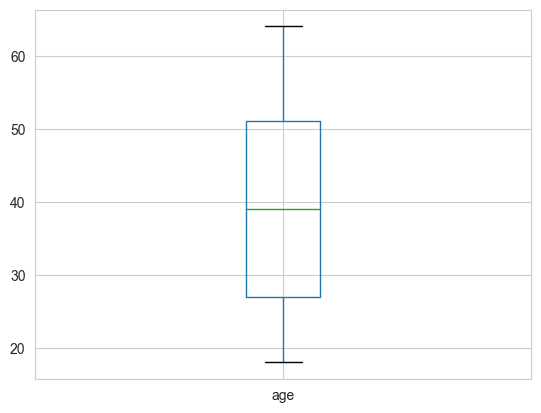

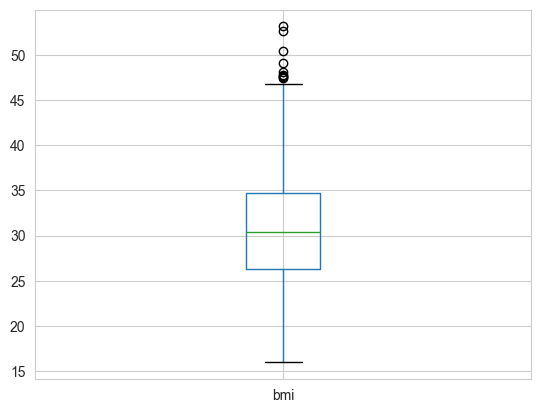

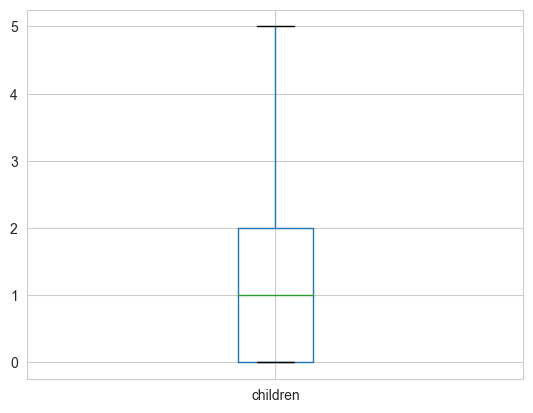

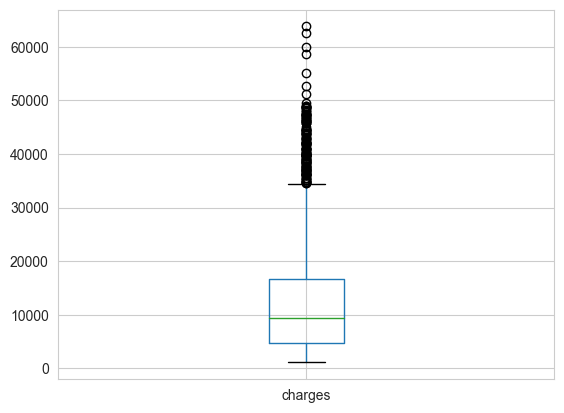

In [6]:
numeric_data = data.select_dtypes(include=[np.number])
for column in list(numeric_data.columns):
    data.boxplot(column)
    plt.show()

Уберем выбросы

In [7]:
filtered_df = (data.loc[(data.charges < 50000) & (data.age < 48)]).reset_index(drop=True)
filtered_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
887,23,female,24.225,2,no,northeast,22395.74424
888,23,female,33.400,0,no,southwest,10795.93733
889,18,female,31.920,0,no,northeast,2205.98080
890,18,female,36.850,0,no,southeast,1629.83350


Уникальные регионы:

In [8]:
regions = set(data.region)
regions

{'northeast', 'northwest', 'southeast', 'southwest'}

# Задание 2
Выполнить однофакторный ANOVA тест, чтобы проверить влияние региона на индекс массы тела (BMI), используя первый способ, через библиотеку Scipy.

Основные условия проведения дисперсионного анализа:
1. Зависимая переменная должна быть непрерывной, неограниченной/изменяющейся в широком интервале и представлена интервальными/характеризующими отношения данными; факторы должны быть дихотомическими/категориальными.

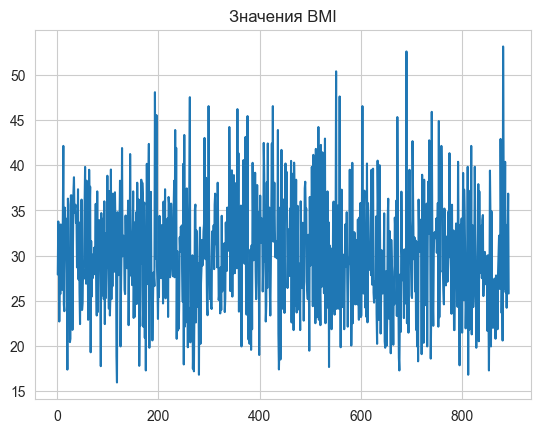

In [9]:
filtered_df['index'] = range(1, len(filtered_df) + 1)
plt.plot(filtered_df['index'], filtered_df['bmi'])
plt.title('Значения BMI')
plt.show()

Условия выполняются.

2. Каждое значение зависимой переменной не должно зависеть от других ее значений. Выполняется.

3. В каждой группе непрерывная переменная имеет приблизительно нормальное распределение. Нормальность распределения можно проверить, используя гистограмму («на глаз») или статистические тесты на нормальность.

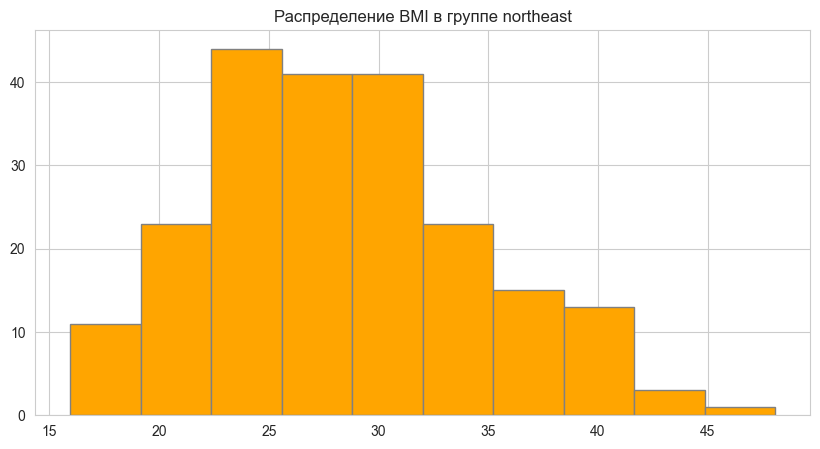

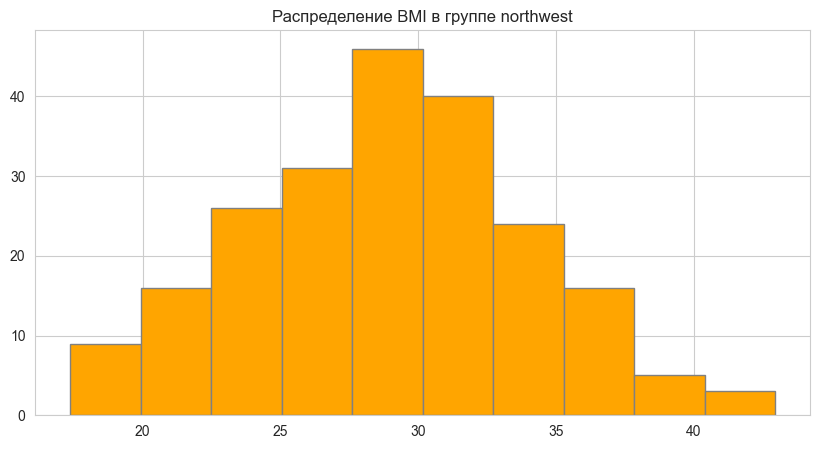

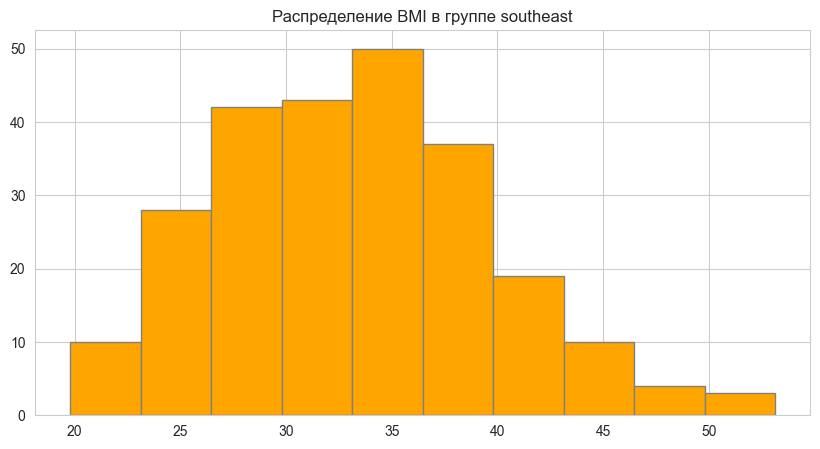

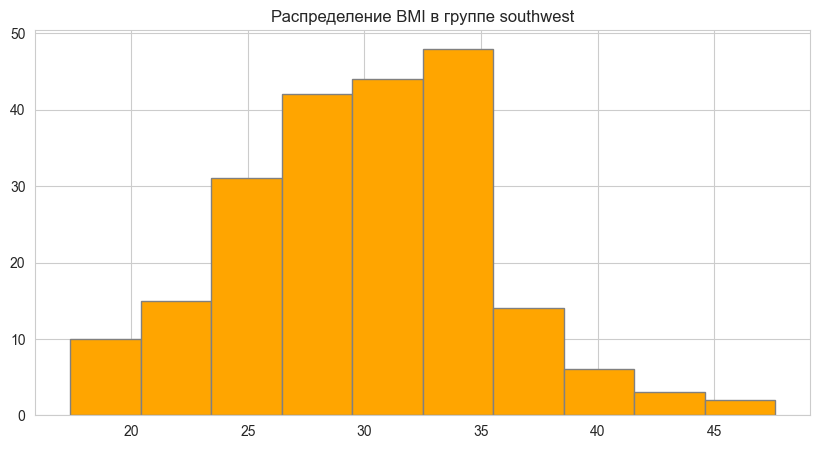

In [10]:
groups_list = list(filtered_df.groupby('region').groups.keys())
values = list()

for i in range(len(groups_list)):
    values.append(filtered_df.loc[filtered_df['region'] == groups_list[i]].reset_index(drop=True)['bmi'])
    filtered_df.loc[filtered_df['region'] == groups_list[i]].reset_index(drop=True)['bmi'].hist(color='orange', edgecolor='grey', figsize=(10,5))
    plt.title(f"Распределение BMI в группе {groups_list[i]}")
    plt.show()

Распределения похожи на нормальные.

4. Дисперсии изучаемых групп должны быть приблизительно одинаковыми. Проверить похожесть дисперсий можно с помощью теста Левина, в котором нулевая гипотеза гласит, что дисперсия однородна, и если результат теста Левина статистически не значим (при применении критерия α < 0,05), то дисперсии достаточно похожи.

In [11]:
stat, p = sts.levene(*values)
p

0.002172184654256795

Ура! Дисперсии похожи, с этим можно жить.

Все нормас, так что приступаем к анализу

In [12]:
class ANOVA:
    def __init__(self, df: pd.DataFrame, columns: list, groupby_column: str, numeric_column: str):
        self.columns = columns
        self.numeric_column = numeric_column
        self.groupby_column = groupby_column
        self.data = pd.DataFrame(df, columns=self.columns)
        groups_list = list(self.data.groupby(groupby_column).groups.keys())
        self.values = list()

        for i in range(len(groups_list)):
            self.values.append(self.data.loc[self.data[groupby_column] == groups_list[i]].reset_index(drop=True)[numeric_column])
        anova_results = sts.f_oneway(*self.values)
        self.f_statistic = anova_results[0]
        self.pvalue = anova_results[1]
        self.f = self.calc_f(show=True)

    def calc_f(self, show=False):
        # среднее значение всех наблюдений
        x_aver_all = 0
        num_column = self.data[self.numeric_column]
        for i in range(len(num_column)):
            x_aver_all += num_column[i]
        n = len(num_column)
        x_aver_all = x_aver_all/n

        # Вычислим общую сумму квадратов
        SST = 0
        for i in range(len(num_column)):
            SST += (num_column[i] - x_aver_all)**2

        # Степени свободы для общей суммы квадратов
        dFsst = n - 1

        # Вычислим средние значения внутри каждой из групп
        average_vals = [0] * len(self.values)
        for group_df in range(len(self.values)):
            average_vals[group_df] = 0
            for i in range(len(self.values[group_df])):
                average_vals[group_df] += self.values[group_df][i]
            average_vals[group_df] = average_vals[group_df]/len(self.values[group_df])

        # Внутригрупповая сумма квадратов
        SSW = 0
        for group_df in range(len(self.values)):
            for i in range(len(self.values[group_df])):
                SSW += (self.values[group_df][i] - average_vals[group_df])**2

        # Степени свободы для внутригрупповой суммы квадратов
        m = len(self.values)
        dFssw = n - m

        # Межгрупповая сумма квадратов
        SSB = 0
        for i in range(len(average_vals)):
            SSB += m*(average_vals[i] - x_aver_all)**2
        dFssb = m - 1

        # Межгрупповая дисперсия
        MSb = SSB/dFssb
        # Внутригрупповая дисперсия:
        MSw = SSW/dFssw
        # Вычислим F-значение:
        F = MSb/MSw
        # Критическое значение
        F_critical = sts.f.ppf(q=0.05, dfn=dFssb, dfd=dFssw)

        if show:
            if SSB > SSW:
                print("Большая часть общей изменчивости обеспечивается благодаря межгрупповой сумме квадратов, значит группы значительно различаются между собой.")
            elif SSB < SSW:
                print("Большая часть общей изменчивости обеспечивается благодаря внутригрупповой сумме квадратов, значит группы схожи между собой.")
            else:
                print("Межгрупповая и внутригрупповая суммы равны.")
            print('--'*20)
            print(f"Вычисления:\n"
                  f"\t> Среднее значение всех наблюдений: {x_aver_all}\n"
                  f"\t> Общая сумма квадратов: {SST}\n"
                  f"\t> Степени свободы общей суммы квадратов: {dFsst}\n"
                  f"\t> Средние значения внутри каждой из групп: {average_vals}\n"
                  f"\t> Внутригрупповая сумма квадратов: {SSW}\n"
                  f"\t> Степени свободы для внутригрупповой суммы квадратов: {dFssw}\n"
                  f"\t> Межгрупповая сумма квадратов: {SSB}\n"
                  f"\t> Степени свободы для межгрупповой суммы квадратов: {dFssb}\n"
                  f"\t> Межгрупповая дисперсия: {MSb}\n"
                  f"\t> Внутригрупповая дисперсия: {MSw}\n"
                  f"\t> F-значение: {F}\n"
                  f"\t> F-критическое: {F_critical}\n")
        return F

    def show_results(self):
        print(f"Results for columns: {self.columns} grouped by '{self.groupby_column}':\n"
              f"\t> f_statistic: {self.f_statistic}\n"
              f"\t> p-value: {self.pvalue}\n")

    def __call__(self, *args, **kwargs):
        self.show_results()

In [13]:
anova_test = ANOVA(df=filtered_df, columns=['region', 'bmi'], groupby_column='region', numeric_column='bmi')()

Большая часть общей изменчивости обеспечивается благодаря внутригрупповой сумме квадратов, значит группы схожи между собой.
----------------------------------------
Вычисления:
	> Среднее значение всех наблюдений: 30.18327354260088
	> Общая сумма квадратов: 33771.661691255584
	> Степени свободы общей суммы квадратов: 891
	> Средние значения внутри каждой из групп: [28.462441860465127, 28.794236111111083, 33.169918699187, 29.88232558139536]
	> Внутригрупповая сумма квадратов: 30504.430027564864
	> Степени свободы для внутригрупповой суммы квадратов: 888
	> Межгрупповая сумма квадратов: 55.605222524140125
	> Степени свободы для межгрупповой суммы квадратов: 3
	> Межгрупповая дисперсия: 18.535074174713376
	> Внутригрупповая дисперсия: 34.3518356166271
	> F-значение: 0.5395657565892042
	> F-критическое: 0.11723935085411533

Results for columns: ['region', 'bmi'] grouped by 'region':
	> f_statistic: 31.703610642078864
	> p-value: 1.793363776557073e-19



Получили:
* pvalue - вероятность того, что нулевая гипотеза верна. В данном случае, p < 0.05, нулевая гипотеза о равенстве групп верна.
* statistic - числовой критерий Фишера, тестовая статистика которого при выполнении нулевой гипотезы имеет распределение Фишера (F-распределение). Критическое значение = дисперсия групповых средних / средняя внутригрупповая дисперсия.

# Задание 3
Выполнить однофакторный ANOVA тест, чтобы проверить влияние региона на индекс массы тела (BMI), используя второй способ, с помощью функции anova_lm() из библиотеки statsmodels.

In [14]:
data_reg_bmi = pd.DataFrame(filtered_df, columns=['region', 'bmi'])
model = ols('bmi ~ region', data = data_reg_bmi).fit()
anova_result = sm.stats.anova_lm(model)
print(anova_result)

             df        sum_sq      mean_sq          F        PR(>F)
region      3.0   3267.231664  1089.077221  31.703611  1.793364e-19
Residual  888.0  30504.430028    34.351836        NaN           NaN


# Задание 4
С помощью t критерия Стьюдента перебрать все пары. Определить поправку Бонферрони. Сделать выводы.

In [15]:
region_pairs = []
regions = list(set(data_reg_bmi['region']))
groups = list(data_reg_bmi.groupby('region').groups.keys())
values = dict()

for i in range(len(groups)):
    values[groups[i]] = data_reg_bmi.loc[data_reg_bmi['region'] == groups[i]].reset_index(drop=True)['bmi']

for region_1 in range(len(regions) - 1):
    for region_2 in range(region_1 + 1, len(regions)):
        region_pairs.append((regions[region_1], regions[region_2]))

# t-test
results = dict()
for region_1, region_2 in region_pairs:
    results[str(region_1) + " " + str(region_2)] = round(sts.ttest_ind(values[region_1], values[region_2])[1], 5)

alpha = 0.05/len(region_pairs)
print(f"Критическое значение альфа = {0.05}")

for key in results.keys():
    if results[key] < alpha:
        print(f"p({key}) = {results[key]} (отклоняется)")
    else:
        print(f"p({key}) = {results[key]} (принимается)")
print(f"Поправка Бонферрони: {round(alpha, 5)}")

Критическое значение альфа = 0.05
p(northwest northeast) = 0.54523 (принимается)
p(northwest southeast) = 0.0 (отклоняется)
p(northwest southwest) = 0.03423 (принимается)
p(northeast southeast) = 0.0 (отклоняется)
p(northeast southwest) = 0.01152 (принимается)
p(southeast southwest) = 0.0 (отклоняется)
Поправка Бонферрони: 0.00833


# Задание 5
Выполнить пост-хок тесты Тьюки и построить график.

In [16]:
data_reg_bmi.head()

,region,bmi
0,southwest,27.900
1,southeast,33.770
2,southeast,33.000
3,northwest,22.705
4,northwest,28.880


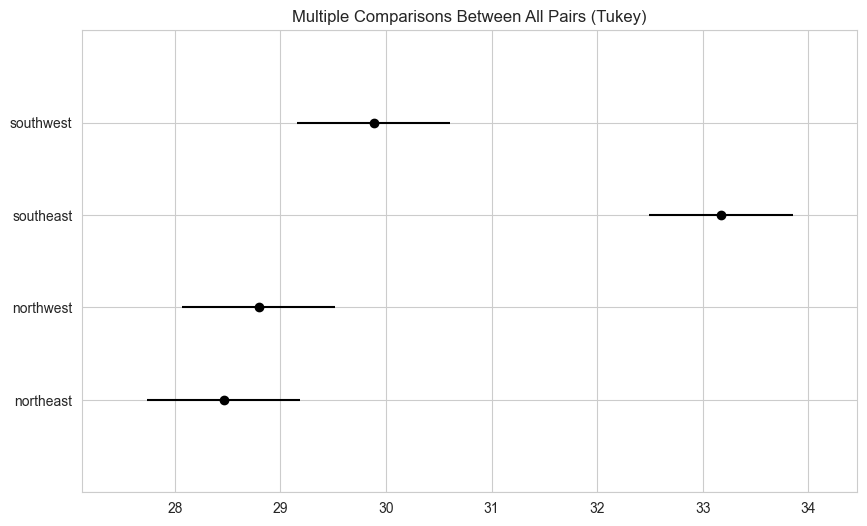

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,0.3318,0.9358,-1.1215,1.7851,False
northeast,southeast,4.7075,0.0,3.2991,6.1159,True
northeast,southwest,1.4199,0.0588,-0.0351,2.8749,False
northwest,southeast,4.3757,0.0,2.969,5.7824,True
northwest,southwest,1.0881,0.2174,-0.3652,2.5414,False
southeast,southwest,-3.2876,0.0,-4.696,-1.8792,True


In [17]:
tukey = pairwise_tukeyhsd(endog=data_reg_bmi['bmi'], groups=data_reg_bmi['region'], alpha=0.05)
tukey.plot_simultaneous()
plt.vlines(x = 50, ymin = -0.5, ymax = 5, color='red')
plt.show()
tukey.summary()

Видим, что доверительные интервалы перекрываются, поэтому постхок southwest-northwest и southwest-northeast тесты показали что различия между ними не существенные.

# Задание 6
Выполнить двухфакторный ANOVA тест, чтобы проверить влияние региона и пола на индекс массы тела (BMI), используя функцию anova_lm() из библиотеки statsmodels.

In [18]:
df = pd.DataFrame(data, columns=['age', 'bmi', 'region'])
df.head()

,age,bmi,region
0,19,27.900,southwest
1,18,33.770,southeast
2,28,33.000,southeast
3,33,22.705,northwest
4,32,28.880,northwest


In [19]:
model = ols('bmi ~ C(region) + C(age)', data=df).fit()
sm.stats.anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(region),3.0,4055.880631,1351.960210,39.518164,1.979856e-24
C(age),46.0,1600.412056,34.791566,1.016967,4.422336e-01
Residual,1288.0,44063.907698,34.211108,NaN,NaN


Таким образом мы видим, что оба значения меньше 0.05, следует, оба фактора статистически влияют на bmi.

# Задание 7
Выполнить пост-хок тесты Тьюки и построить график.

In [20]:
filtered_df['combination'] = np.nan

for i in range(len(filtered_df['combination'])):
    filtered_df['combination'][i] = str(filtered_df.region[i]) + " / " + str(filtered_df.sex[i])

C:\Users\orono\AppData\Local\Temp\ipykernel_20312\2585767815.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['combination'][i] = str(filtered_df.region[i]) + " / " + str(filtered_df.sex[i])


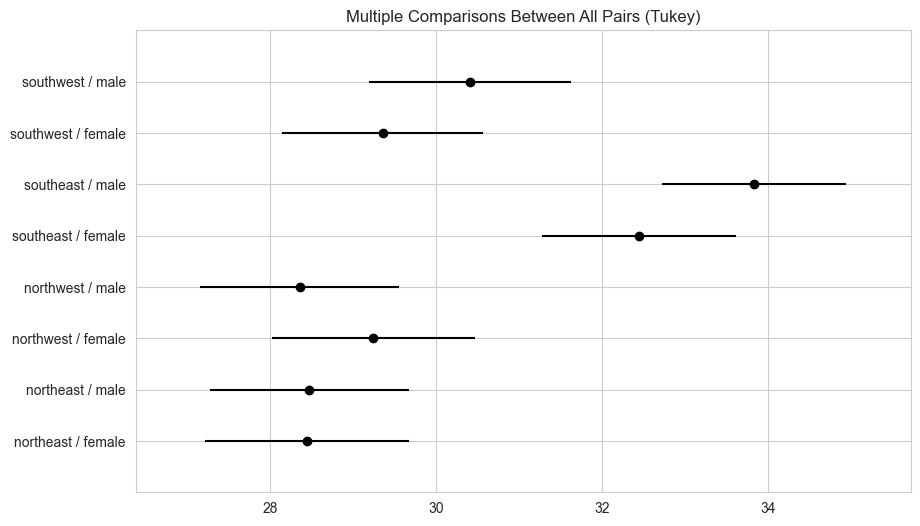

group1,group2,meandiff,p-adj,lower,upper,reject
northeast / female,northeast / male,0.0239,1.0,-2.4024,2.4501,False
northeast / female,northwest / female,0.7936,0.9766,-1.6549,3.2421,False
northeast / female,northwest / male,-0.0893,1.0,-2.5155,2.337,False
northeast / female,southeast / female,3.9932,0.0,1.6026,6.3837,True
northeast / female,southeast / male,5.3786,0.0,3.0412,7.716,True
northeast / female,southwest / female,0.9109,0.9489,-1.5263,3.3481,False
northeast / female,southwest / male,1.9582,0.2255,-0.4846,4.401,False
northeast / male,northwest / female,0.7698,0.979,-1.6506,3.1902,False
northeast / male,northwest / male,-0.1131,1.0,-2.511,2.2847,False
northeast / male,southeast / female,3.9693,0.0,1.6076,6.3311,True


In [21]:
tukey = pairwise_tukeyhsd(endog=filtered_df['bmi'], groups=filtered_df['combination'], alpha=0.05)
tukey.plot_simultaneous()
plt.vlines(x = 50, ymin = -0.5, ymax = 5, color='red')
plt.show()
tukey.summary()

Не очень красиво выглядит, конечно. Но видно, что зависимость есть - можно провести вертикальную линию, которая будет соединять горизонтальные.